In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

# from kaggle.api.kaggle_api_extended import KaggleApi
# import kagglehub

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

from minisom import MiniSom

os.environ["OMP_NUM_THREADS"]="7"

In [2]:
# api = KaggleApi()
# api.authenticate()

In [3]:
# !chcp 65001
# path = %pwd

In [4]:
# api.dataset_download_files("dwdkills/alcohol-consumption-in-russia", path = path, unzip = True)

In [5]:
os.listdir()

['.ipynb_checkpoints', '4 лаба.ipynb', 'russia_alcohol.csv']

In [6]:
df = pd.read_csv('russia_alcohol.csv')
df.head()

,year,region,wine,beer,vodka,champagne,brandy
0,1998,Republic of Adygea,1.9,8.8,3.4,0.3,0.1
1,1998,Altai Krai,3.3,19.2,11.3,1.1,0.1
2,1998,Amur Oblast,2.1,21.2,17.3,0.7,0.4
3,1998,Arkhangelsk Oblast,4.3,10.6,11.7,0.4,0.3
4,1998,Astrakhan Oblast,2.9,18.0,9.5,0.8,0.2


In [7]:
df = df.dropna()

In [8]:
regions = df['region'].values
df_numeric = df.select_dtypes(np.number)

In [9]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_numeric)

In [10]:
som_shape = (10,10)
input_len = df_numeric.shape[1]
som = MiniSom(x=som_shape[0], y=som_shape[1], input_len=input_len, sigma=0.5, learning_rate=0.0001)

In [11]:
som.random_weights_init(data_scaled)
som.train_random(data_scaled, 100)

Text(0.5, 1.0, 'U-матрица (Топографическая карта SOM)')

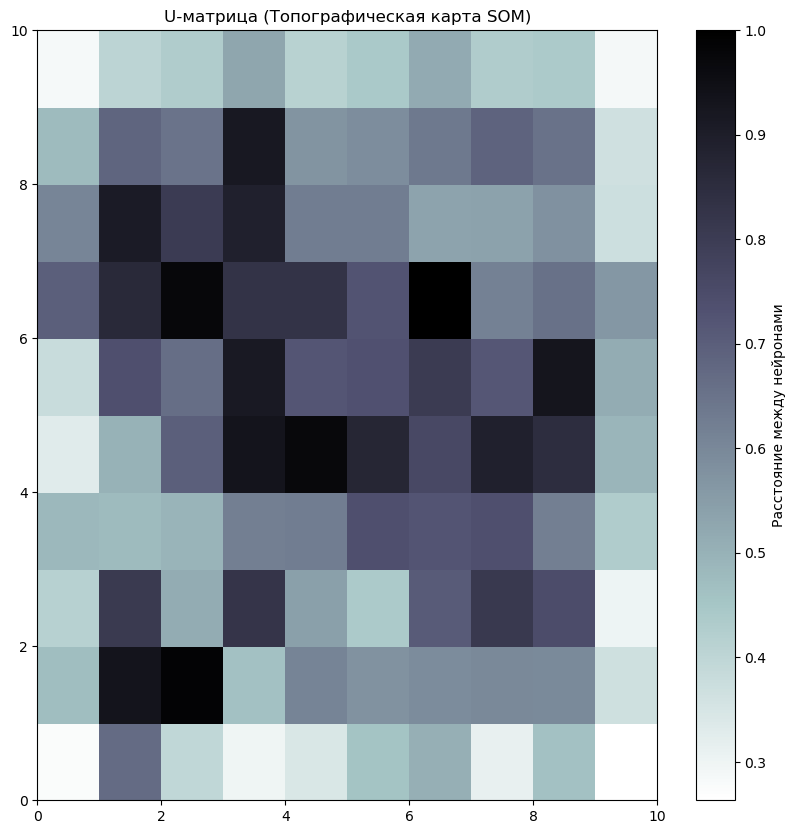

In [12]:
plt.figure(figsize=(10, 10))
plt.pcolor(som.distance_map().T, cmap='bone_r')  # U-матрица
plt.colorbar(label='Расстояние между нейронами')
plt.title('U-матрица (Топографическая карта SOM)')

In [13]:
winner_coordinates = np.array([som.winner(x) for x in data_scaled])
cluster_map = {tuple(coord): idx for idx, coord in enumerate(np.unique(winner_coordinates, axis=0))}
labels_som = np.array([cluster_map[tuple(coord)] for coord in winner_coordinates])

In [14]:
silhouette_score(data_scaled, labels_som)

0.08157560608503098

In [30]:
silhouette_scores = []
cluster_range = range(80, 100) 

In [31]:
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(data_scaled)
    score = silhouette_score(data_scaled, labels)
    silhouette_scores.append(score)
    #print(f"K = {k} коэффициент силуэта: {score:.4f}")

C:\Users\Matvey\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Matvey\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
C:\Users\Matvey\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Matvey\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the envir

C:\Users\Matvey\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Matvey\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
C:\Users\Matvey\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Matvey\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the envir

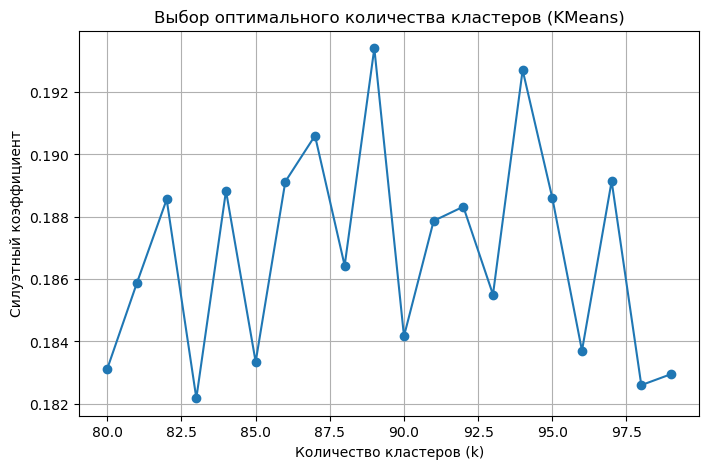

In [32]:
# === Визуализация ===
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.xlabel("Количество кластеров (k)")
plt.ylabel("Силуэтный коэффициент")
plt.title("Выбор оптимального количества кластеров (KMeans)")
plt.grid(True)
plt.show()

In [18]:
k_best = cluster_range[np.argmax(silhouette_scores)]
kmeans = KMeans(n_clusters=k_best, random_state=42)
labels_kmeans = kmeans.fit_predict(data_scaled)

C:\Users\Matvey\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Matvey\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


In [19]:
comparison_df = pd.DataFrame({
    'Регион': regions,
    'Кластер_SOM': labels_som,
    'Кластер_KMeans': labels_kmeans
})

In [20]:
print(len(comparison_df['Кластер_SOM'].unique()))
print(len(comparison_df['Кластер_KMeans'].unique()))

100
2
